### Siamese Neural Networks are extremely popular for image classification,facial identification tasks,etc.
In this notebook, I will be using a Siamese Neural network to find out whether they are suitable to distinguish between
real and forged signatures, I will link the dataset I am using in the readme.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import os
import torch.nn.functional as F
import torch.utils.data as utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import torchvision
from torch.autograd import Variable
from PIL import Image
from tqdm import tqdm


device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [5]:
import numpy as np
import matplotlib.pyplot as plt


def imshow(img, text=None, should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(
            75,
            8,
            text,
            style="italic",
            fontweight="bold",
            bbox={"facecolor": "white", "alpha": 0.8, "pad": 10},
        )
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()

Creating the dataset from the folder

In [6]:
from email.mime import image


class Dataset():

    def __init__(self,train_csv,train_dir,transform=None) -> None:
        self.train_df=pd.read_csv(train_csv)
        self.train_df.columns =["image1","image2","label"]
        self.train_dir = train_dir
        self.transform = transform

    def __getitem__(self,index):
        image1_dir = os.path.join(self.train_dir,self.train_df.iat[index,0])
        image2_dir = os.path.join(self.train_dir,self.train_df.iat[index,1])
        image_0 = Image.open(image1_dir)
        image_1 = Image.open(image2_dir)
        image_0 = image_0.convert("L")
        image_1 = image_1.convert("L")
        if self.transform is not None:
            image_0 = self.transform(image_0)
            image_1 = self.transform(image_1)
        return image_0,image_1,torch.from_numpy(np.array([int(self.train_df.iat[index,2])],dtype=np.float32))

    def __len__(self):
        return len(self.train_df)

In [7]:
train_csv = "./data/train_data.csv"
train_dir = "./data/train/"
dataset = Dataset(
    train_csv,
    train_dir=train_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

In [8]:
class SiameseNn(nn.Module):
    def __init__(self):
        super(SiameseNn, self).__init__()
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),

            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),

            nn.Linear(128,2))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

A simple Cross entropy loss will not work for this, we must use something else

In [9]:
class LossFunction(nn.Module):

    def __init__(self,margin=1.0):
        super(LossFunction,self).__init__()
        self.margin = margin

    def forward(self,x0,x1,y):
        diff = x0-x1
        sq = torch.sum(torch.pow(diff,2),1)
        dist = torch.sqrt(sq)
        mdist = self.margin - dist
        dist = torch.clamp(mdist, min=0.0)
        loss = y * sq + (1 - y) * torch.pow(dist, 2)
        loss = torch.sum(loss) / 2.0 / x0.size()[0]
        return loss

In [10]:
WEIGHT_DECAY = 0.0005
LEARNING_RATE = 1e-3
EPOCHS = 15
BATCH_SIZE = 32

In [11]:
model = SiameseNn().to(device)
criterion = LossFunction()
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)

In [12]:
train_dataloader = DataLoader(dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=BATCH_SIZE)


eval_dataloader = DataLoader(dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [13]:
def train(train_dataloader):
    loss = []
    count = []
    iter = 0
    for epoch in tqdm(range(1,EPOCHS)):
        for i,data in enumerate(train_dataloader,0):
            img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = model(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        loss.append(loss_contrastive.item())
        loss = np.array(loss)
        return loss.mean()/len(train_dataloader)

In [14]:
def eval(eval_dataloader):
    loss=[]
    counter=[]
    iteration_number = 0
    for i, data in enumerate(eval_dataloader,0):
      img0, img1 , label = data
      img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
      output1,output2 = model(img0,img1)
      loss_contrastive = criterion(output1,output2,label)
      loss.append(loss_contrastive.item())
    loss = np.array(loss)
    return loss.mean()/len(eval_dataloader)

In [15]:
for epoch in range(1,EPOCHS):
    best_eval_loss:int = 9999
    train_loss = train(train_dataloader)
    eval_loss = eval(eval_dataloader)
    print(f"Training Loss: {train_loss}")
    print("-" * 25)
    print(f"Eval loss: {eval_loss}")
    if eval_loss < best_eval_loss:
        best_eval_loss = eval_loss
        print("-"*20)
        print(f"Best Eval loss{best_eval_loss}")
        torch.save(model.state_dict(), "model.pth")
        print("Model Saved Successfully")

  0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
  0%|          | 0/14 [03:56<?, ?it/s]


Training Loss: 0.0027374121111614974
-------------------------
Eval loss: 0.007297133454630074
--------------------
Best Eval loss0.007297133454630074
Model Saved Successfully


  0%|          | 0/14 [02:43<?, ?it/s]


Training Loss: 0.0009115414678557845
-------------------------
Eval loss: 0.11172055185055113
--------------------
Best Eval loss0.11172055185055113
Model Saved Successfully


  0%|          | 0/14 [02:42<?, ?it/s]


Training Loss: 0.01151492641648642
-------------------------
Eval loss: 0.016516287634821415
--------------------
Best Eval loss0.016516287634821415
Model Saved Successfully


  0%|          | 0/14 [02:42<?, ?it/s]


Training Loss: 0.0008227014837186199
-------------------------
Eval loss: 0.007225162170747155
--------------------
Best Eval loss0.007225162170747155
Model Saved Successfully


  0%|          | 0/14 [02:45<?, ?it/s]


Training Loss: 0.0014857917449362678
-------------------------
Eval loss: 0.007766706061363763
--------------------
Best Eval loss0.007766706061363763
Model Saved Successfully


  0%|          | 0/14 [02:46<?, ?it/s]


Training Loss: 0.0014214855580290486
-------------------------
Eval loss: 0.0080447750688047
--------------------
Best Eval loss0.0080447750688047
Model Saved Successfully


  0%|          | 0/14 [02:45<?, ?it/s]


Training Loss: 0.0011989146717323745
-------------------------
Eval loss: 0.00721202234627974
--------------------
Best Eval loss0.00721202234627974
Model Saved Successfully


  0%|          | 0/14 [02:46<?, ?it/s]


Training Loss: 0.001992025979622665
-------------------------
Eval loss: 0.007565700835568591
--------------------
Best Eval loss0.007565700835568591
Model Saved Successfully


  0%|          | 0/14 [02:45<?, ?it/s]


Training Loss: 0.0009234585381079639
-------------------------
Eval loss: 0.011327369556350358
--------------------
Best Eval loss0.011327369556350358
Model Saved Successfully


  0%|          | 0/14 [02:44<?, ?it/s]


Training Loss: 0.0021560623954478705
-------------------------
Eval loss: 0.009837684266538407
--------------------
Best Eval loss0.009837684266538407
Model Saved Successfully


  0%|          | 0/14 [02:43<?, ?it/s]


Training Loss: 0.0013476805581862604
-------------------------
Eval loss: 0.008114638721632867
--------------------
Best Eval loss0.008114638721632867
Model Saved Successfully


  0%|          | 0/14 [02:44<?, ?it/s]


Training Loss: 0.0012132217568799485
-------------------------
Eval loss: 0.007203480551598351
--------------------
Best Eval loss0.007203480551598351
Model Saved Successfully


  0%|          | 0/14 [02:42<?, ?it/s]


Training Loss: 0.000877458448252402
-------------------------
Eval loss: 0.007036924557594334
--------------------
Best Eval loss0.007036924557594334
Model Saved Successfully


  0%|          | 0/14 [02:41<?, ?it/s]


Training Loss: 0.0007194979295914495
-------------------------
Eval loss: 0.007240181175610243
--------------------
Best Eval loss0.007240181175610243
Model Saved Successfully


In [17]:
test_csv = "../data/test_data.csv"
test_dir = "./data/test/"

test_dataset = Dataset(
    train_csv=test_csv,
    train_dir=test_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

test_dataloader = DataLoader(test_dataset, num_workers=6, batch_size=1, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


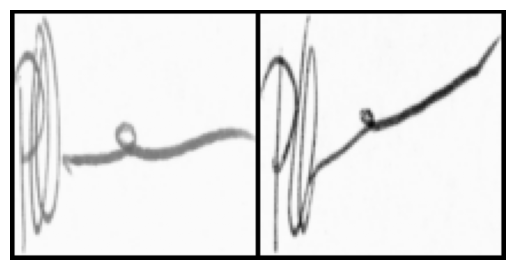

Predicted Eucledian Distance:- 0.13488318026065826
Actual Label:- !!!!FORGED Pair of Signatures found


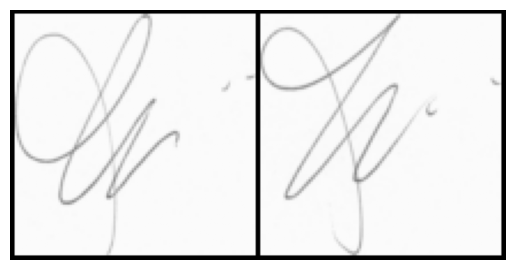

Predicted Eucledian Distance:- 0.09363754838705063
Actual Label:- Original Pair Of Signature


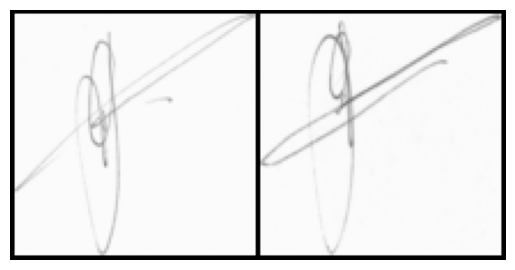

Predicted Eucledian Distance:- 0.19223524630069733
Actual Label:- Original Pair Of Signature


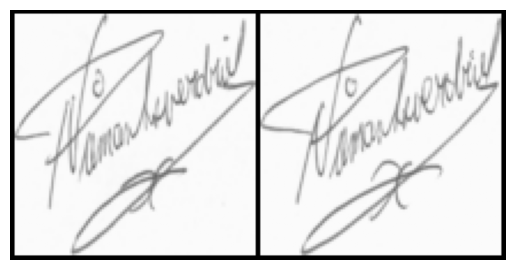

Predicted Eucledian Distance:- 0.43282464146614075
Actual Label:- Original Pair Of Signature


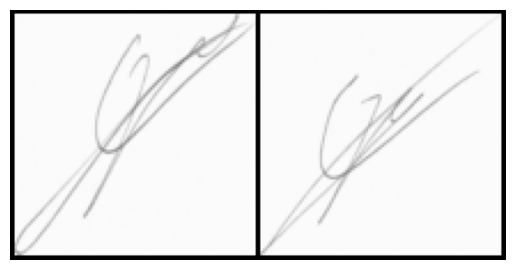

Predicted Eucledian Distance:- 0.05507609620690346
Actual Label:- Original Pair Of Signature


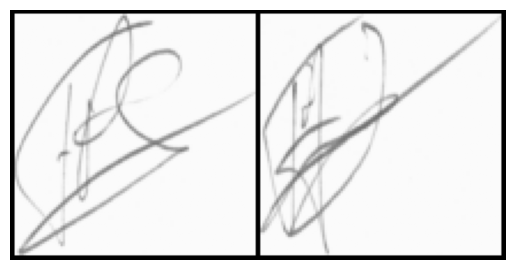

Predicted Eucledian Distance:- 0.32195109128952026
Actual Label:- Original Pair Of Signature


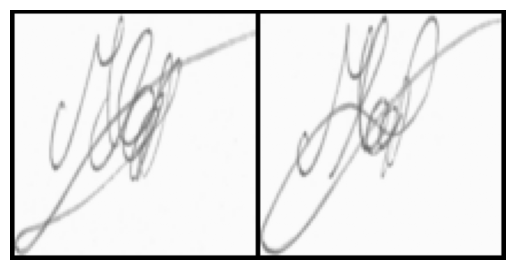

Predicted Eucledian Distance:- 0.47833582758903503
Actual Label:- Original Pair Of Signature


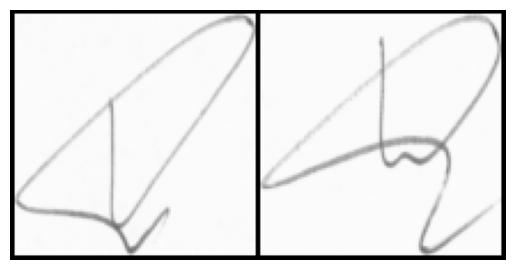

Predicted Eucledian Distance:- 0.35348132252693176
Actual Label:- Original Pair Of Signature


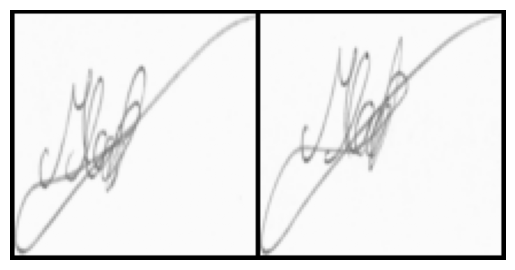

Predicted Eucledian Distance:- 0.17305400967597961
Actual Label:- Original Pair Of Signature


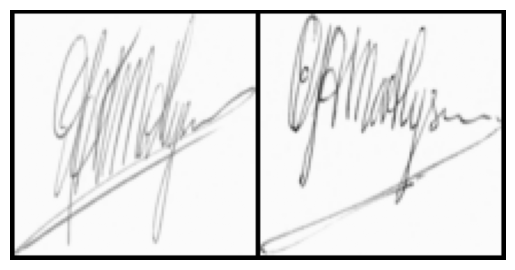

Predicted Eucledian Distance:- 0.309190571308136
Actual Label:- !!!!FORGED Pair of Signatures found


In [18]:
count = 0
for i, data in enumerate(test_dataloader, 0):
    x0, x1, label = data
    concat = torch.cat((x0, x1), 0)
    output1, output2 = model(x0.to(device), x1.to(device))

    eucledian_distance = F.pairwise_distance(output1, output2)

    if label == torch.FloatTensor([[0]]):
        label = "Original Pair Of Signature"
    else:
        label = "!!!!FORGED Pair of Signatures found"

    imshow(torchvision.utils.make_grid(concat))
    print("Predicted Eucledian Distance:-", eucledian_distance.item())
    print("Actual Label:-", label)
    count = count + 1
    if count == 10:
        break